# Feature Engineering on MBTI dataset!

In [1]:
reset -fs

In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("mbti_1.csv")

In [4]:
all_posts = list(df['posts'])
all_posts = [post.split("|||") for post in all_posts]

### Average number of posts that exceed word limit for dataset

In [5]:
avg_long_posts = []
for user_posts in all_posts:
    avg_long_posts.append(sum(1 for post in user_posts if post.endswith("..."))/50)
assert(len(avg_long_posts) == df.shape[0])

In [6]:
df['avg_long_post'] = avg_long_posts

### Average number of posts which are links

In [7]:
avg_link_posts = []
for user_posts in all_posts:
    avg_link_posts.append(sum(1 for post in user_posts if "http" in post)/50)
assert(len(avg_link_posts) == df.shape[0])

In [8]:
df['avg_links'] = avg_link_posts
df.tail()

,type,posts,avg_long_post,avg_links
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,0.10,0.14
8671,ENFP,'So...if this thread already exists someplace ...,0.62,0.04
8672,INTP,'So many questions when i do these things. I ...,0.32,0.04
8673,INFP,'I am very conflicted right now when it comes ...,0.88,0.00
8674,INFP,'It has been too long since I have been on per...,0.44,0.06


### Average number of words per post

In [9]:
import re

regex = "(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-;=])?([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-;=])" # Modified from https://stackoverflow.com/a/6041965
posts_links_removed = []
post_word_length = []
for user_posts in all_posts:
    user_posts_temp = [re.sub(regex, '', post) for post in user_posts] # Remove all urls from posts.
    user_posts_word_ct = [len(post.split()) for post in user_posts_temp] # Get number of words in each post.
    posts_links_removed.append(user_posts_temp)
    post_word_length.append(np.mean(user_posts_word_ct))
assert(len(post_word_length) == df.shape[0])

# Storing posts with links removed for later use.
df_nlp = pd.DataFrame()
df_nlp['posts_links_removed'] = posts_links_removed

In [10]:
df['avg_word_ct'] = post_word_length
df.tail()

,type,posts,avg_long_post,avg_links,avg_word_ct
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,0.10,0.14,16.78
8671,ENFP,'So...if this thread already exists someplace ...,0.62,0.04,27.12
8672,INTP,'So many questions when i do these things. I ...,0.32,0.04,19.90
8673,INFP,'I am very conflicted right now when it comes ...,0.88,0.00,35.08
8674,INFP,'It has been too long since I have been on per...,0.44,0.06,28.14


### Average number of question marks per post

In [11]:
question_ct = []
for user_posts in df_nlp['posts_links_removed']:
    question_ct.append(sum(post.count('?') for post in user_posts)/50)

In [12]:
df['avg_question_marks'] = question_ct
df.tail()

,type,posts,avg_long_post,avg_links,avg_word_ct,avg_question_marks
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908||...,0.10,0.14,16.78,0.10
8671,ENFP,'So...if this thread already exists someplace ...,0.62,0.04,27.12,0.20
8672,INTP,'So many questions when i do these things. I ...,0.32,0.04,19.90,0.14
8673,INFP,'I am very conflicted right now when it comes ...,0.88,0.00,35.08,0.18
8674,INFP,'It has been too long since I have been on per...,0.44,0.06,28.14,0.06


### Average sentiment per post

In [13]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()
post_sentiments = []
for user_posts in df_nlp['posts_links_removed']:
    user_posts_temp = [post for post in user_posts if len(post.strip()) > 0] # Remove posts that are only links.
    user_sentiments = [analyzer.polarity_scores(post)['compound'] for post in user_posts_temp] # Get sentiment scores of each post.
    post_sentiments.append(np.mean(user_sentiments))

In [14]:
df['avg_sentiment'] = post_sentiments
df.to_csv("mbti_tomo_1.csv") # Save the csv because the above took a long time to run.
df.head()

,type,posts,avg_long_post,avg_links,avg_word_ct,avg_question_marks,avg_sentiment
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...,0.16,0.42,11.64,0.04,0.053766
1,ENTP,'I'm finding the lack of me in these posts ver...,0.36,0.14,24.20,0.08,0.354146
2,INTP,'Good one _____ https://www.youtube.com/wat...,0.26,0.10,17.60,0.18,0.223073
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0.46,0.04,22.22,0.18,0.174424
4,ENTJ,'You're fired.|||That's another silly misconce...,0.40,0.12,20.20,0.16,0.038181


## Some EDA

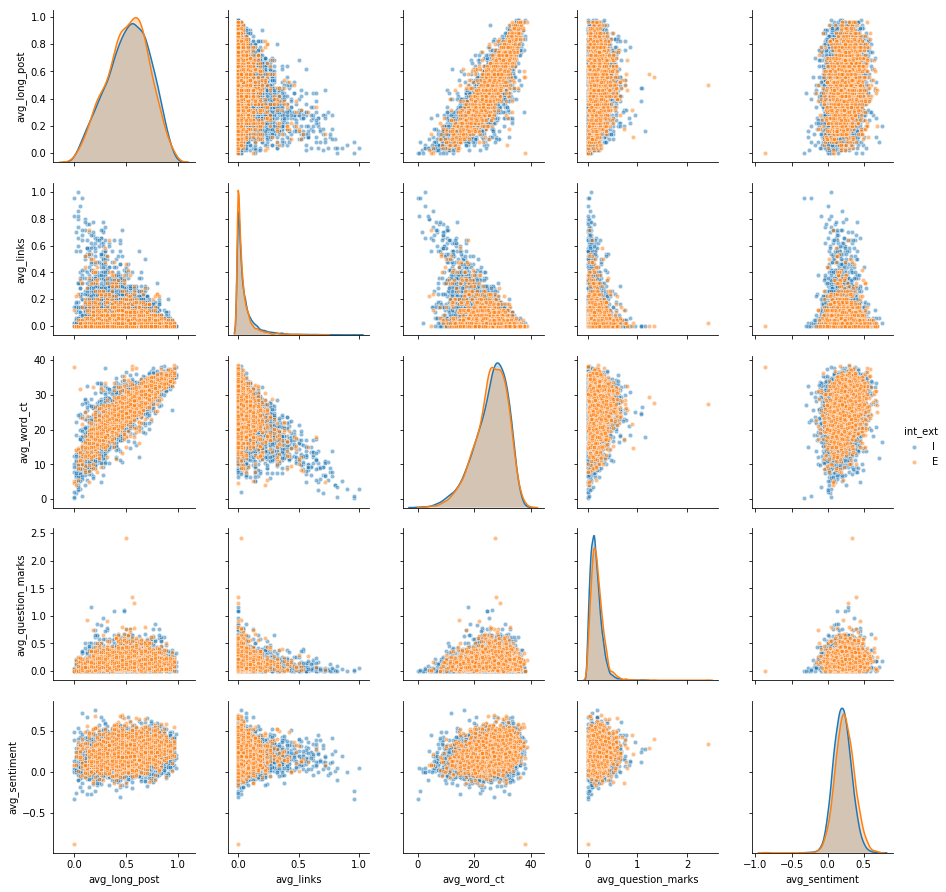

In [19]:
import seaborn as sns

df['int_ext'] = [type[0] for type in df['type']]
sns.pairplot(df, hue="int_ext", plot_kws={"s": 20, "alpha": 0.5})

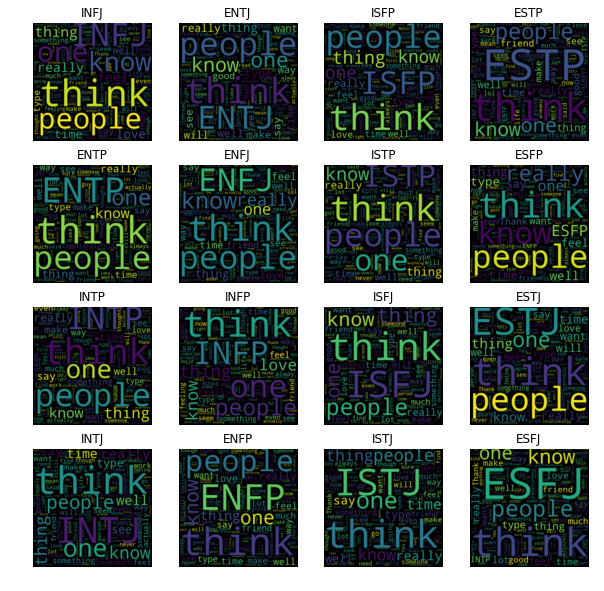

In [51]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

dim = int(len(df['type'].unique())**0.5)
fig, ax = plt.subplots(nrows=dim, ncols=dim, figsize=(10, 10))
j = 0
for i, mbti_type in enumerate(df['type'].unique()):
    if i % dim == 0 and i != 0:
        j += 1
    posts = [post for user_posts in df_nlp[df['type'] == mbti_type]['posts_links_removed'] for post in user_posts] 
    cloud = WordCloud(height=400).generate(" ".join(posts))
    ax[i%dim,j].imshow(cloud, interpolation='bilinear')
    ax[i%dim,j].axis("off")
    ax[i%dim,j].set_title(mbti_type)